# SEIR & PR Model for COVID19 Global forecast

SEIR MODEL Reference:
* Many thanks for @datasaurus great Kernel : https://www.kaggle.com/anjum48/seir-model-with-intervention
* [Compartmental models in epidemiology - SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)
* [SEIR Great APP](http://gabgoh.github.io/COVID/index.html)

PR model Reference:
* [My previous kernel](https://www.kaggle.com/super13579/covid19-global-forcast-simple-eda-pr-model)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import numpy
import datetime
from datetime import timedelta

%matplotlib inline

## SEIR Model function
* Function From [SEIR Great APP](http://gabgoh.github.io/COVID/index.html)
![image.png](https://upload.wikimedia.org/wikipedia/commons/3/3d/SEIR.PNG)
* S ==> Susceptible : number of susceptible
* E ==> Expose : number of expose
* I ==> Infectious : number of infectious
* R ==> Recovered or Removed : number recovered (or immune) individuals. 
* We have S + E + I + R = N, this is only constant because of the (degenerate) assumption that birth and death rates are equal, N is country population.

Susceptible → Exposed → Infected → Removed, Differential Function as below (from [SEIR Great APP](http://gabgoh.github.io/COVID/index.html)): 
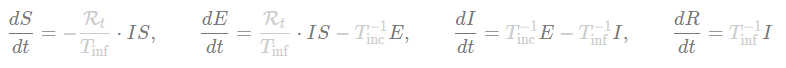
We need to solve the Differential equation to find the S,E,I,R, but what is **"R_t"**, **"T_inf"**, **"T_inc"** and how can we define those variable?
* R_0 & R_t ==> [Reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number), The definition describes the state where no other individuals are infected or immunized (naturally or through vaccination)
* T_inf ==> Average duration of the infection, 1/T_inf can be treat as individual experiences one recovery in D units of time.
* T_inc ==> Average incubation period, Many paper and article define as 5.1 ([reference](https://www.ncbi.nlm.nih.gov/pubmed/32150748), [reference2](https://www.worldometers.info/coronavirus/coronavirus-incubation-period/))

### Assume there are some intervention will cause reproduction number (R_0) reduce (such as bed nets and vaccines,government, isolation ....), have an effectiveness which decays over time 

In [68]:
# Function code refernece from https://www.kaggle.com/anjum48/seir-model-with-intervention

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    
    return [S_out, E_out, I_out, R_out]

## Let's try simple SEIR model on Hubei
* Already defined R0, T_inf, T_inc. 
* Compare invention and non-invention condition on SEIR model.

### Load dataset (Global ComfirmedCase of each country)

In [69]:
train = pd.read_csv("C:/Users/KHUSHI GANDHI/Downloads/owid-monkeypox-data.csv")
test = pd.read_csv("C:/Users/KHUSHI GANDHI/Downloads/owid-monkeypox-data.csv")
train['Date_datetime'] = train['date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))

### Load populations of each country

In [70]:
pop_info = pd.read_csv("C:/Users/KHUSHI GANDHI/Downloads/population_data.csv")
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

### Plot SEIR model and predict

In [71]:
def plot_model_and_predict(data, pop, solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y
    
    f = plt.figure(figsize=(16,5))
    ax = f.add_subplot(1,2,1)
    #ax.plot(sus, 'b', label='Susceptible');
    ax.plot(exp, 'y', label='Exposed');
    ax.plot(inf, 'r', label='Infected');
    ax.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');
    
    ax2 = f.add_subplot(1,2,2)
    preds = np.clip((inf + rec) * pop ,0,np.inf)
    ax2.plot(range(len(data)),preds[:len(data)],label = 'Predict ConfirmedCases')
    ax2.plot(range(len(data)),data['total_cases'])
    plt.title('Model predict and data')
    plt.ylabel("Population", fontsize=10);
    plt.xlabel("Days", fontsize=10);
    plt.legend(loc='best');

### Model without intervention
* We can see the without intervention, Hubei comfirmedcase will keep increase... this is very terrifying.

### Model with intervention
* There are different way to reduce R_t, [Differnt decay function](https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions) as below, we are using hill function
![image](https://raw.githubusercontent.com/wiki/SwissTPH/openmalaria/img/graphs/decay-functions.png)
This could be modified to take any function of `R_t(t)` values to model the reproduction number as a time varying variable
* Result shows the predict value greate fit the current comfirmedcases
* You can also using different decay function as above to reduce "R_t"

In [23]:
train

,iso_code,location,date,new_cases,new_cases_smoothed,total_cases,new_cases_per_million,total_cases_per_million,new_cases_smoothed_per_million,new_deaths,new_deaths_smoothed,total_deaths,new_deaths_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,Date_datetime
0,AND,Andorra,2022-07-25,1.0,NaN,1.0,12.653,12.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25
1,AND,Andorra,2022-07-26,2.0,NaN,3.0,25.306,37.958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-26
2,AND,Andorra,2022-07-27,0.0,NaN,3.0,0.000,37.958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-27
3,AND,Andorra,2022-07-28,0.0,NaN,3.0,0.000,37.958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-28
4,AND,Andorra,2022-07-29,0.0,NaN,3.0,0.000,37.958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,OWID_WRL,World,2022-08-22,2063.0,950.57,44186.0,0.261,5.587,0.120,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22
4949,OWID_WRL,World,2022-08-23,1444.0,968.29,45630.0,0.183,5.769,0.122,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23
4950,OWID_WRL,World,2022-08-24,1048.0,949.14,46678.0,0.133,5.902,0.120,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-24
4951,OWID_WRL,World,2022-08-25,559.0,880.00,47237.0,0.071,5.972,0.111,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-25


In [29]:
Country = 'United Arab Emirates'
N = pop_info[pop_info['Name']==Country]['Population'].tolist()[0] # Hubei Population 

# Load dataset of Hubei
train_loc = train[train['location']==Country].query('total_cases> 0')
if len(train_loc)==0:
    train_loc = train[train['location']==Country].query('total_cases> 0')
#train_loc['total_cases_per_million'].round().astype(int)


,iso_code,location,date,new_cases,new_cases_smoothed,total_cases,new_cases_per_million,total_cases_per_million,new_cases_smoothed_per_million,new_deaths,new_deaths_smoothed,total_deaths,new_deaths_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,Date_datetime
15,ARE,United Arab Emirates,2022-05-24,1.0,NaN,1.0,0.107,0.107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-24
16,ARE,United Arab Emirates,2022-05-25,0.0,NaN,1.0,0.000,0.107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-25
17,ARE,United Arab Emirates,2022-05-26,0.0,NaN,1.0,0.000,0.107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-26
18,ARE,United Arab Emirates,2022-05-27,0.0,NaN,1.0,0.000,0.107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-27
19,ARE,United Arab Emirates,2022-05-28,0.0,NaN,1.0,0.000,0.107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,ARE,United Arab Emirates,2022-07-20,0.0,0.00,13.0,0.000,1.388,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-20
73,ARE,United Arab Emirates,2022-07-21,0.0,0.00,13.0,0.000,1.388,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-21
74,ARE,United Arab Emirates,2022-07-22,0.0,0.00,13.0,0.000,1.388,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-22
75,ARE,United Arab Emirates,2022-07-23,0.0,0.00,13.0,0.000,1.388,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-23


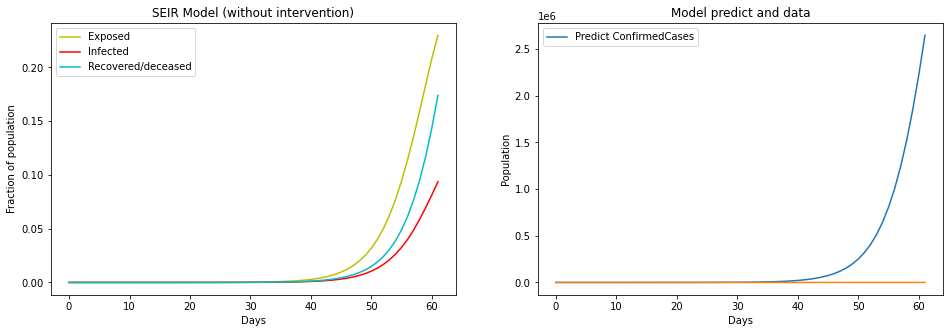

In [74]:
Country = 'United Arab Emirates'
N = pop_info[pop_info['Name']==Country]['Population'].tolist()[0] # Hubei Population 

# Load dataset of Hubei
train_loc = train[train['location']==Country].query('total_cases> 0')
if len(train_loc)==0:
    train_loc = train[train['location']==Country].query('total_cases> 0')
n_infected = train_loc['total_cases'].iloc[0] # start from first comfirmedcase on dataset first date
max_days = len(train_loc)# how many days want to predict

# Initial stat for SEIR model
s = (N - n_infected)/ N
e = 0.
i = n_infected / N
r = 0.

# Define all variable of SEIR model 
T_inc = 5.2  # average incubation period
T_inf = 2.9 # average infectious period
R_0 = 3.954 # reproduction number

## Solve the SEIR model 
sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(R_0, T_inf, T_inc), 
                t_eval=np.arange(max_days))

## Plot result
plot_model_and_predict(train_loc, N, sol, title = 'SEIR Model (without intervention)')

### Model with intervention
* There are different way to reduce R_t, [Differnt decay function](https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions) as below, we are using hill function
![image](https://raw.githubusercontent.com/wiki/SwissTPH/openmalaria/img/graphs/decay-functions.png)
This could be modified to take any function of `R_t(t)` values to model the reproduction number as a time varying variable
* Result shows the predict value greate fit the current comfirmedcases
* You can also using different decay function as above to reduce "R_t"

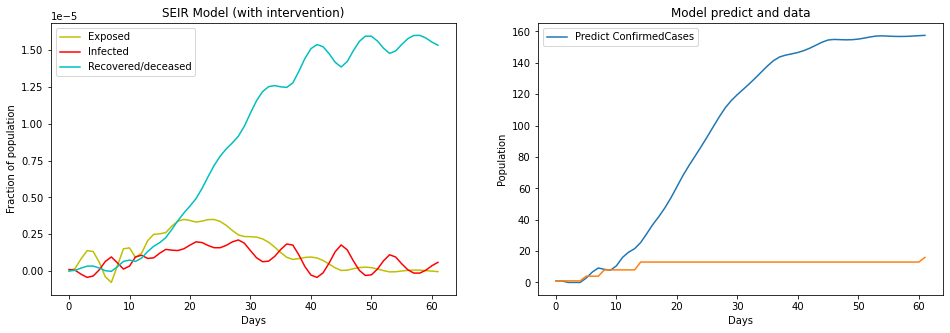

In [75]:
# Define all variable of SEIR model 
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period

# Define the intervention parameters (fit result, latter will show how to fit)
R_0, cfr, k, L=[ 3.95469597 , 0.04593316 , 3.      ,   15.32328881]

def time_varying_reproduction(t): 
    return R_0 / (1 + (t/L)**k)

sol2 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model_and_predict(train_loc, N, sol2, title = 'SEIR Model (with intervention)')

## Fit the SEIR model to real data
Find the best variables of SEIR model to fit the real data
* T_inf ==> Using average value 2.9 
* T_inc ==> Using average value 5.2
* **R_t** ==> find the best reproduction number by fitting the real data (if have decay function, find the paramater of decay function)
* **cfr** ==> find the best Case fatality rate, this parater is for predict Fatalities

In [76]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

### Cumsum signal
* to prevent fluctuation

In [55]:
def cumsum_signal(vec):
    temp_val = 0
    vec_new = []
    for i in vec:
        if i > temp_val:
            vec_new.append(i)
            temp_val = i
        else:
            vec_new.append(temp_val)
    return vec_new

### Intervention by after days for SEIR model
* after days, start interverntion, R0 = R0 * 0.5

In [56]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['total_cases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # R0 become half after intervention days
    def time_varying_reproduction(t):
        if t > 80: # we set intervention days = 80
            return R_0 * 0.5
        else:
            return R_0
    
    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['total_cases'].values
    
    # Predict total_deaths by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['total_deaths'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

### Intervention by Hill function for SEIR model
* https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions

In [77]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr, k, L = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['total_cases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['total_cases'].values
    
    # Predict total_deaths by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['total_deaths'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

### Function of Fit the SEIR model to real data
* Auto choose the best decay function of R_t (intervention days decay or Hill decay)
* Total case/country population is below 1, reduce country population
* If datset still no case, return 0 
* Plot the fit result and forecast trends (Infect smooth decrease by what date)
* Function being hide, there are describe in code.

In [98]:
from matplotlib import dates
import plotly.graph_objects as go

def fit_model_new(data, area_name, initial_guess=[2.2, 0.02, 2, 50], 
              bounds=((1, 20), (0, 0.15), (1, 3), (1, 100)), make_plot=True, decay_mode = None):
    
    if area_name in ['United Arab Emirates']:
        train = data.query('total_cases > 0').copy()[:-1]
    else:
        train = data.query('total_cases > 0').copy()
    
    ####### Split Train & Valid #######
    valid_data = train[-7:].copy()
    train_data = train[:-7].copy()
    
    ####### If this country have no ConfirmedCase, return 0 #######
    if len(train_data) == 0:
        result_zero = np.zeros((43))
        return pd.DataFrame({'total_cases':result_zero,'total_deaths':result_zero}), 0 
    
    ####### Load the population of area #######
    try:
        #population = province_lookup[area_name]
        population = pop_info[pop_info['Name']==area_name]['Population'].tolist()[0]
    except IndexError:
        print ('country not in population set, '+str(area_name))
        population = 1000000 
    
    
    if area_name == 'Belgium':
        population = 327200000
        
    if area_name == 'World':
        population = 7744240900
        
   
    n_infected = train_data['total_cases'].iloc[0]
    
    ####### Total case/popuplation below 1, reduce country population #######
    if train_data[train_data['total_cases_per_million']] < 1:
        #print ('reduce pop divide by 100')
        population = population/100
        
    ####### Fit the real data by minimize the MSLE #######
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')

    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    ####### Align the date information #######
    test_end = datetime.datetime.strptime('2020-08-26','%Y-%m-%d')
    test_start = datetime.datetime.strptime('2020-05-06','%Y-%m-%d')
    test_period = (test_end - test_start).days
    train_max = train_data.Date_datetime.max()
    train_all_max = train.Date_datetime.max()
    train_min = train_data.Date_datetime.min()
    add_date = 0
    delta_days =(test_end - train_max).days
    train_add_time=[]

    if train_min > test_start:
        add_date = (train_min-test_start).days
        last = train_min-timedelta(add_date)
        train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
        train_add_time = pd.to_datetime(train_add_time)
        dates_all = train_add_time.append(pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]')))
    else:
        dates_all = pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]'))


    ####### Auto find the best decay function ####### 
    if decay_mode is None:
        if res_const.fun < res_decay.fun :
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
            res = res_const

        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
            res = res_decay
            R_0, cfr, k, L = res.x
    else:
        if decay_mode =='day_decay':
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
            res = res_const
        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
            res = res_decay
            R_0, cfr, k, L = res.x

    ####### Predict the result by using best fit paramater of SEIR model ####### 
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'total_cases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
       # 'total_cases': [inf[0]*population for i in range(add_date)]+(np.clip((inf + rec) * population,0,np.inf)).tolist(),
       # 'total_deaths': [rec[0]*population for i in range(add_date)]+(np.clip(rec, 0, np.inf) * population * res.x[1]).tolist()
        'total_deaths': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())
    })

    y_pred_valid = y_pred.iloc[len(train_data):len(train_data)+len(valid_data)]
    #y_pred_valid = y_pred.iloc[:len(train_data)]
    y_pred_test = y_pred.iloc[-(test_period+1):]
    #y_true_valid = train_data[['total_cases', 'total_deaths']]
    y_true_valid = valid_data[['total_cases', 'total_deaths']]
    #print (len(y_pred),train_min)
    #print (y_true_valid['total_cases'])
    #print (y_pred_valid['total_cases'])
    ####### Calculate MSLE ####### 
    valid_msle_cases = mean_squared_log_error(y_true_valid['total_cases'], y_pred_valid['total_cases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['total_deaths'], y_pred_valid['total_deaths'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    ####### Plot the fit result of train data and forecast after 300 days ####### 
    if make_plot:
        if len(res.x)<=2:
            print(f'Validation MSLE: {valid_msle:0.5f}, using intervention days decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')
        else:
            print(f'Validation MSLE: {valid_msle:0.5f}, using Hill decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}, K : {res.x[2]:0.5f}, L: {res.x[3]:0.5f}')
        
        ####### Plot the fit result of train data dna SEIR model trends #######

        f = plt.figure(figsize=(16,5))
        ax = f.add_subplot(1,2,1)
        ax.plot(exp, 'y', label='Exposed');
        ax.plot(inf, 'r', label='Infected');
        ax.plot(rec, 'c', label='Recovered/deceased');
        plt.title('SEIR Model Trends')
        plt.xlabel("Days", fontsize=10);
        plt.ylabel("Fraction of population", fontsize=10);
        plt.legend(loc='best');
        #train_date_remove_year = train_data['Date_datetime'].apply(lambda date:'{:%m-%d}'.format(date))
        ax2 = f.add_subplot(1,2,2)
        xaxis = train_data['Date_datetime'].tolist()
        xaxis = dates.date2num(xaxis)
        hfmt = dates.DateFormatter('%m\n%d')
        ax2.xaxis.set_major_formatter(hfmt)
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),train_data['total_cases'],label='Confirmed Cases (train)', c='g')
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), y_pred['total_cases'][:len(train_data)],label='Cumulative modeled infections', c='r')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'), y_true_valid['total_cases'],label='Confirmed Cases (valid)', c='b')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'),y_pred_valid['total_cases'],label='Cumulative modeled infections (valid)', c='y')
        plt.title('Real ConfirmedCase and Predict ConfirmedCase')
        plt.legend(loc='best');
        plt.show()
            
        ####### Forecast 300 days after by using the best paramater of train data #######
        if len(res.x)>2:
            msle, sol = eval_model_decay(res.x, train_data, population, True, 300)
        else:
            msle, sol = eval_model_const(res.x, train_data, population, True, 300)
        
        sus, exp, inf, rec = sol.y
        
        y_pred = pd.DataFrame({
            'total_cases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
            'total_deaths': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
        })
        
        ####### Plot 300 days after of each country #######
        start = train_min
        end = start + timedelta(len(y_pred))
        time_array = np.arange(start, end, dtype='datetime64[D]')

        max_day = numpy.where(inf == numpy.amax(inf))[0][0]
        where_time = time_array[max_day]
        pred_max_day = y_pred['total_cases'][max_day]
        xy_show_max_estimation = (where_time, max_day)
        
        con = y_pred['total_cases']
        max_day_con = numpy.where(con == numpy.amax(con))[0][0] # Find the max confimed case of each country
        max_con = numpy.amax(con)
        where_time_con = time_array[len(time_array)-50]
        xy_show_max_estimation_confirmed = (where_time_con, max_con)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_array, y=y_pred['total_cases'].astype(int),
                            mode='lines',
                            line = dict(color='red'),
                            name='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date())))
        
        fig.add_trace(go.Scatter(x=time_array[:len(train)], y=train['total_cases'],
                            mode='lines',
                            name='Confirmed case until '+ str(train_all_max.date()),line = dict(color='green', width=4)))
        fig.add_annotation(
            x=where_time_con,
            y=max_con-(max_con/30),
            showarrow=False,
            text="Estimate Max Case around:" +str(int(max_con)),
            font=dict(
                color="Blue",
                size=15
            ))
        fig.add_annotation(
            x=time_array[len(train)-1],
            y=train['total_cases'].tolist()[-1],
            showarrow=True,
            text=f"Real Max ConfirmedCase: " +str(int(train['total_cases'].tolist()[-1]))) 
        
        fig.add_annotation(
            x=where_time,
            y=pred_max_day,
            text='Infect start decrease from: ' + str(where_time))   
        fig.update_layout(title='Estimate Confirmed Case ,'+area_name+' Total population ='+ str(int(population)), legend_orientation="h")
        fig.show()
        
        #df = pd.DataFrame({'Values': train_data['total_cases'].tolist()+y_pred['total_cases'].tolist(),'Date_datatime':time_array[:len(train_data)].tolist()+time_array.tolist(),
        #           'Real/Predict': ['ConfirmedCase' for i in range(len(train_data))]+['PredictCase' for i in range(len(y_pred))]})
        #fig = px.line(df, x="Date_datatime", y="Values",color = 'Real/Predict')
        #fig.show()
        #plt.figure(figsize = (16,7))
        #plt.plot(time_array[:len(train_data)],train_data['total_cases'],label='Confirmed case until '+ str(train_max.date()),color='g', linewidth=3.0)
        #plt.plot(time_array,y_pred['total_cases'],label='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date()),color='r', linewidth=1.0)
        #plt.annotate('Infect start decrease from: ' + str(where_time), xy=xy_show_max_estimation, size=15, color="black")
        #plt.annotate('max Confirmedcase: ' + str(int(max_con)), xy=xy_show_max_estimation_confirmed, size=15, color="black")
        #plt.title('Estimate Confirmed Case '+area_name+' Total population ='+ str(int(population)))
        #plt.legend(loc='lower right')
        #plt.show()


    return y_pred_test, valid_msle

## Let's fit SEIR model on country
* Check Taiwan(My country!!), South Korean, Japan, Italy, New York
* Hope these are not ture... Italy and New York are very terrifying....

In [101]:
country = 'Argentina'
if country not in train['location'].unique():
    country_pd_train = train[train['location']==country]
else:
    country_pd_train = train[train['location']==country]

a,b = fit_model_new(country_pd_train,country,make_plot=True)

KeyError: "None of [Float64Index([0.044, 0.044, 0.044, 0.044, 0.044, 0.044, 0.044, 0.044, 0.044,\n              0.044, 0.044, 0.044, 0.044, 0.066, 0.066, 0.066, 0.066, 0.066,\n              0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.088, 0.088,\n              0.088, 0.088, 0.088, 0.088, 0.088,  0.11,  0.11, 0.133, 0.133,\n              0.133, 0.133, 0.133, 0.133, 0.133, 0.133, 0.199, 0.199, 0.199,\n              0.199, 0.199, 0.265, 0.287, 0.287, 0.287, 0.287, 0.287, 0.287,\n              0.287, 0.287, 0.398, 0.398, 0.398, 0.398, 0.442, 0.508, 0.508,\n              0.508, 0.508, 0.508, 0.508, 0.508, 0.817, 0.817, 0.817, 0.817,\n              0.817, 0.817, 0.817, 1.082, 1.082, 1.082, 1.082, 1.082, 1.082,\n               1.59,  1.59],\n             dtype='float64')] are in the [columns]"

In [81]:
country = 'Korea, South'
if country not in train['Country_Region'].unique():
    country_pd_train = train[train['Province_State']==country]
else:
    country_pd_train = train[train['Country_Region']==country]

a,b = fit_model_new(country_pd_train,country,make_plot=True)

KeyError: 'Country_Region'

In [82]:
country = 'Japan'
if country not in train['Country_Region'].unique():
    country_pd_train = train[train['Province_State']==country]
else:
    country_pd_train = train[train['Country_Region']==country]

a,b = fit_model_new(country_pd_train,country,make_plot=True)

KeyError: 'Country_Region'

In [83]:
country = 'Italy'
if country not in train['Country_Region'].unique():
    country_pd_train = train[train['Province_State']==country]
else:
    country_pd_train = train[train['Country_Region']==country]

a,b = fit_model_new(country_pd_train,country,make_plot=True)

KeyError: 'Country_Region'

In [85]:
country = 'New York'
if country not in train['Country_Region'].unique():
    country_pd_train = train[train['Province_State']==country]
else:
    country_pd_train = train[train['Country_Region']==country]

a,b = fit_model_new(country_pd_train,country,make_plot=True)

KeyError: 'Country_Region'

### Check the total US trend

In [86]:
country = 'US'
country_pd_train = train[train['Country_Region']==country]
country_pd_train2 = country_pd_train.groupby(['Date']).sum().reset_index()
country_pd_train2['Date_datetime'] = country_pd_train2['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))
a,b = fit_model_new(country_pd_train2,country,make_plot=True)

KeyError: 'Country_Region'

### Global Forecast !!!

In [104]:
country = 'United Arab Emirates'
country_pd_train2 = train.groupby(['date']).sum().reset_index()
country_pd_train2['Date_datetime'] = country_pd_train2['date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))
a,b = fit_model_new(country_pd_train2,country,make_plot=True)

KeyError: "None of [Float64Index([              0.015,               0.015,                0.12,\n                             0.12,                0.12,                0.12,\n              0.13599999999999998,               0.151,               0.151,\n                             0.21,\n              ...\n                934.7040000000001,   923.2429999999999,             993.198,\n                          912.582,             914.561,             917.801,\n                          944.987,             956.586,             984.566,\n                          907.649],\n             dtype='float64', length=105)] are in the [columns]"

## Predict all Country/Region and Province/States
* Counting all Country/Region MSLE & predict
* If MSLE is lower than 1 , using PR model to retrain and check the performance

In [88]:
import numpy
validation_scores = []
validation_county = []
validation_country = []
for country in tqdm(train['Country_Region'].unique()):
    country_pd_train = train[train['Country_Region']==country]
    #if country_pd_train['Province_State'].isna().unique()==True:
    if len(country_pd_train['Province_State'].unique())<2:
        predict_test, score = fit_model_new(country_pd_train,country,make_plot=False)
        if score ==0:
            print(f'{country} no case')
        validation_scores.append(score)
        validation_county.append(country)
        validation_country.append(country)
        test.loc[test['Country_Region']==country,'ConfirmedCases'] = predict_test['ConfirmedCases'].tolist()
        test.loc[test['Country_Region']==country,'Fatalities'] = predict_test['Fatalities'].tolist()
    else:
        for state in country_pd_train['Province_State'].unique():
            if state != state: # check nan
                state_pd = country_pd_train[country_pd_train['Province_State'].isna()]
                predict_test, score = fit_model_new(state_pd,state,make_plot=False)
                if score ==0:
                    print(f'{country} / {state} no case')
                validation_scores.append(score)
                validation_county.append(state)
                validation_country.append(country)
                test.loc[(test['Country_Region']==country)&(test['Province_State'].isna()),'ConfirmedCases'] = predict_test['ConfirmedCases'].tolist()
                test.loc[(test['Country_Region']==country)&(test['Province_State'].isna()),'Fatalities'] = predict_test['Fatalities'].tolist()
            else:
                state_pd = country_pd_train[country_pd_train['Province_State']==state]
                predict_test, score = fit_model_new(state_pd,state,make_plot=False)
                if score ==0:
                    print(f'{country} / {state} no case')
                validation_scores.append(score)
                validation_county.append(state)
                validation_country.append(country)
                test.loc[(test['Country_Region']==country)&(test['Province_State']==state),'ConfirmedCases'] = predict_test['ConfirmedCases'].tolist()
                test.loc[(test['Country_Region']==country)&(test['Province_State']==state),'Fatalities'] = predict_test['Fatalities'].tolist()
         #   print(f'{country} {state} {score:0.5f}')
            
print(f'Mean validation score: {np.average(validation_scores):0.5f}')

KeyError: 'Country_Region'

In [21]:
validation_scores = pd.DataFrame({'country/state':validation_country,'country':validation_county,'MSLE':validation_scores})
validation_scores.sort_values(by=['MSLE'], ascending=False).head(20)

,country/state,country,MSLE
236,Turkey,Turkey,3.387909
260,US,Michigan,2.363874
250,US,Idaho,1.175098
189,Niger,Niger,1.174793
299,United Kingdom,Falkland Islands (Malvinas),1.078315
177,Montenegro,Montenegro,0.999576
12,Australia,South Australia,0.994732
153,Kosovo,Kosovo,0.773285
20,Bangladesh,Bangladesh,0.763982
170,Malta,Malta,0.660028


In [22]:
large_msle = validation_scores[validation_scores['MSLE']>1]

## Retrain PR model for MSLE>1 countries
* If MSLE of PR model lower than SEIR model, than use PR model as predict result

In [89]:
test_end = datetime.datetime.strptime('2020-05-14','%Y-%m-%d')
test_start = datetime.datetime.strptime('2020-04-02','%Y-%m-%d')
train_max = train.Date_datetime.max()
train_min = train.Date_datetime.min()
delta_days =(test_end - train_max).days
all_days =(test_end - train_min).days
test_days = (test_end - test_start).days
delta_days,all_days,test_days

(-834, -722, 42)

In [90]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

for country in large_msle['country'].unique():
    if (country!= country)==False: # check None
        #print ('training model for country ==>'+country)
        country_pd_train = train[train['Country_Region']==country]
        country_pd_test = test[test['Country_Region']==country]
        if len(country_pd_train)==0:
            country_pd_train = train[train['Province_State']==country]
            country_pd_test = test[test['Province_State']==country]

            x = np.array(range(len(country_pd_train))).reshape((-1,1))[:-7]
            valid_x = np.array(range(len(country_pd_train))).reshape((-1,1))[-7:]
            y = country_pd_train['ConfirmedCases'][:-7]
            valid_y = country_pd_train['ConfirmedCases'][-7:]
            y_fat = country_pd_train['Fatalities'][:-7]
            valid_y_fat = country_pd_train['Fatalities'][-7:]
            
            model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model = model.fit(x, y)

            model_fat = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model_fat = model_fat.fit(x, y_fat)
            
            predict_y = model.predict(valid_x)
            predict_yfat = model_fat.predict(valid_x)
            score = mean_squared_log_error(np.clip(valid_y,0,np.inf), np.clip(predict_y,0,np.inf))
            score_fat = mean_squared_log_error(np.clip(valid_y_fat,0,np.inf), np.clip(predict_yfat,0,np.inf))
            score = (score+score_fat)/2

            print(f'{country} {score:0.5f}')
            if score < large_msle[large_msle['country']==country]['MSLE'].tolist()[0]:
                validation_scores.loc[validation_scores['country']==country,'MSLE'] = score
                predict_x = (np.array(range(all_days))).reshape((-1,1))
                test.loc[test['Province_State']==country,'ConfirmedCases'] = model.predict(predict_x)[-43:]
                test.loc[test['Province_State']==country,'Fatalities'] = model_fat.predict(predict_x)[-43:]
        else:
            x = np.array(range(len(country_pd_train))).reshape((-1,1))[:-7]
            valid_x = np.array(range(len(country_pd_train))).reshape((-1,1))[-7:]
            y = country_pd_train['ConfirmedCases'][:-7]
            valid_y = country_pd_train['ConfirmedCases'][-7:]
            y_fat = country_pd_train['Fatalities'][:-7]
            valid_y_fat = country_pd_train['Fatalities'][-7:]
            
            model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model = model.fit(x, y)

            model_fat = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model_fat = model_fat.fit(x, y_fat)
            
            predict_y = model.predict(valid_x)
            predict_yfat = model_fat.predict(valid_x)
            score = mean_squared_log_error(np.clip(valid_y,0,np.inf), np.clip(predict_y,0,np.inf))
            score_fat = mean_squared_log_error(np.clip(valid_y_fat,0,np.inf), np.clip(predict_yfat,0,np.inf))
            score = (score+score_fat)/2

            print(f'{country} {score:0.5f}')
            if score < large_msle[large_msle['country']==country]['MSLE'].tolist()[0]:
                validation_scores.loc[validation_scores['country']==country,'MSLE'] = score
                predict_x = (np.array(range(all_days))).reshape((-1,1))
                test.loc[test['Country_Region']==country,'ConfirmedCases'] = model.predict(predict_x)[-43:]
                test.loc[test['Country_Region']==country,'Fatalities'] = model_fat.predict(predict_x)[-43:]

NameError: name 'large_msle' is not defined

## Submit result

In [91]:
val_soces = validation_scores['MSLE'].tolist()
print(f'Mean validation score: {np.average(val_soces):0.5f}')

TypeError: list indices must be integers or slices, not str

In [92]:
submit = pd.read_csv('../input/covid19-global-forecasting-week-4/submission.csv')
submit['Fatalities'] = test['Fatalities'].astype('float')
submit['ConfirmedCases'] = test['ConfirmedCases'].astype('float')
submit.to_csv('submission.csv',index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/covid19-global-forecasting-week-4/submission.csv'

In [93]:
submit.head()

NameError: name 'submit' is not defined

# Conclusion
* This SEIR model is for idea Compartmental models in epidemiology, it's rough
* R0 reduce can be cause by many things (government, Medical system, calture(habit to wear mask), people behavior)
* We can using real data of recover for each country to define "T_inf"

# Hope COVID-19 will be under control soon